# Exercise 10
## Wavelets in Image Processing

In [19]:
%pylab inline
import cv2
import numpy as np
from scipy import signal
import pywt

Populating the interactive namespace from numpy and matplotlib


First we load 'lena' as grayscale image and convert it to float32. Afterwards we plot the image.

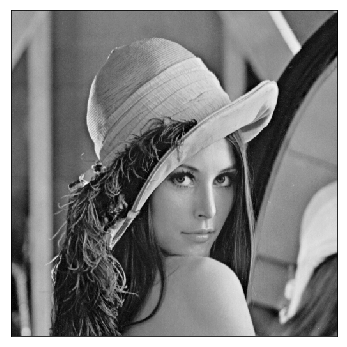

In [20]:
img = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32)
img /= 255.0

figure(figsize(6, 6))
plt.imshow(img, 'gray');
plt.xticks([]),plt.yticks([]);

Now develop a 2-D discrete wavelet transform using Haar wavelets. 

Consider the pipeline:
<img src="wavelet_pipeline.jpg">

Step 1: The output of the first low pass (g) is called 'approximation' and the output of the first high pass is called 'detail'. Use signal.convolve2d(img, filter_kernel, boundary='wrap') to create those first level outputs. For downsampling, only the columns should be downsampled, because we filter in x-direction only and have redundand data here, however, the data on the y-axis is not affected and thus not redundand. (Hint: array_new = array[1::2,1::2] stores every second element in array_new).

Step 2: Calculate HH, HL, LH and LL according to the pipeline (use signal.convolve2d() again). To filter in y-direction, you can transpose the kernels. As way filter in y-direction now, downsample in this direction.

In [21]:
def dht2(img):
    # filter kernels for low and high pass filtering
    g = 1.0 / np.sqrt(2) * np.asarray([[1, 1]])
    h = 1.0 / np.sqrt(2) * np.asarray([[-1, 1]])

    # rows
    sig = np.copy(img)
    approximation = signal.convolve2d(sig, g, boundary='wrap')[:,1::2]
    # 'wrap' specifies that the convolution should wrap around if elements
    # of the filter kernel leave the image. This leads to the first and last
    # column in the convoluted image being equal. 
    # We crop the first columns for that reason and sample 
    # down by a factor of 2 
    detail = signal.convolve2d(sig, h, boundary='wrap')[:,1::2]

    # copy image
    sig = np.copy(approximation)
    approx = signal.convolve2d(sig, g.T, boundary='wrap')[1::2,:]
    detailH = signal.convolve2d(sig, h.T, boundary='wrap')[1::2,:]

    sig = np.copy(detail)

    detailV = signal.convolve2d(sig, g.T, boundary='wrap')[1::2,:]
    detailD = signal.convolve2d(sig, h.T, boundary='wrap')[1::2,:]

    return [approx, detailH, detailV, detailD]

We test the function above and take a look at the results. All images should have a size of 256x256.

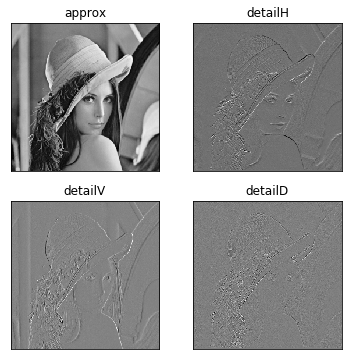

In [22]:
[approx, detailH, detailV, detailD] = dht2(img)
f1 = plt.subplot(2, 2, 1)
plt.xticks([]),plt.yticks([])
plt.imshow(approx, 'gray');
f1.set_title('approx');
f2 = plt.subplot(2, 2, 2)
plt.xticks([]),plt.yticks([])
plt.imshow(detailH, 'gray');
f2.set_title('detailH');
f3 = plt.subplot(2, 2, 3)
plt.xticks([]),plt.yticks([])
plt.imshow(detailV, 'gray');
f3.set_title('detailV');
f4 = plt.subplot(2, 2, 4)
plt.xticks([]),plt.yticks([])
plt.imshow(detailD, 'gray');
f4.set_title('detailD');


We developed a dhtw2 function. The package 'pywavelets' includes this function, too (dwt2()). For reconstruction, we use pywavelets $idwt2((approximation_image, (detailH, detailV, detailD)), 'haar')$ function.

In [23]:
[approx, detailH, detailV, detailD] = dht2(img)
img_r = pywt.idwt2((approx, (detailH, detailV, detailD)), 'haar')

We plot the results and the difference.

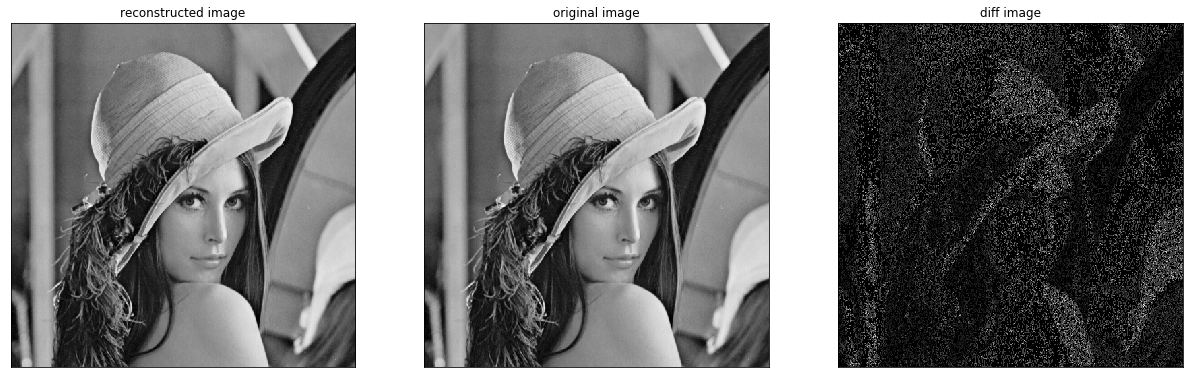

In [24]:
plt.figure(figsize(21,7))
f1 = plt.subplot(1, 3, 1)
plt.xticks([]),plt.yticks([])
plt.imshow(img_r, 'gray');
f1.set_title('reconstructed image');
f2 = plt.subplot(1, 3, 2)
plt.xticks([]),plt.yticks([])
plt.imshow(img, 'gray');
f2.set_title('original image');
f3 = plt.subplot(1, 3, 3)
plt.xticks([]),plt.yticks([])
plt.imshow(np.abs(img-img_r), 'gray');
f3.set_title('diff image');

The next step is to implement the multi-resolution scheme for the wavelet transform.

Therefore, implement a loop to perform the two methods on multiple scales,  i.e.,  to repeatedly encode the low-low coeffcients of the previous step.  Conversely, the inverse discrete wavelet transform should also be able to operate on multiple scales

In [25]:
def mra2(img, ndec):

    [rows, cols] = shape(img)
    # resulting multi-resoultion image
    waveletcoeffs = np.copy(img)

    # for number of decades
    for i in range(0, ndec):
        # apply the dhtw2() and save the results in 4 images
        [approx, detailH, detailV, detailD] = dht2(waveletcoeffs[0:rows,0:cols])

        # halving the images size
        rows //= 2
        cols //= 2
        
        #write the images to the resulting images: top left - approx, top right - LH, bottom left - HL, bottom right HH
        waveletcoeffs[0:rows,0:cols] = approx
        waveletcoeffs[0:rows,cols:2*cols] = detailH
        waveletcoeffs[rows:2*rows,0:cols] = detailV
        waveletcoeffs[rows:2*rows,cols:2*cols] = detailD

    return waveletcoeffs

We test it here. Play around with n_dec.

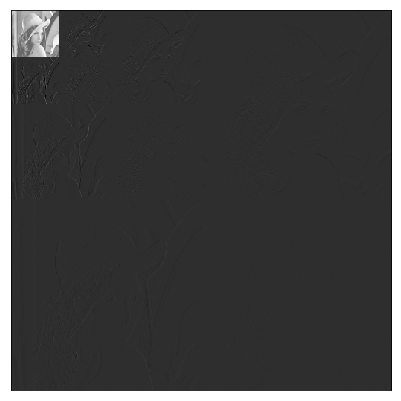

In [26]:
ndec = 3
wc = mra2(img, ndec)

plt.imshow(wc, 'gray');
plt.xticks([]),plt.yticks([]);

We can now take a look at the histogram of our coefficients. We notice that most values are located and around 0.

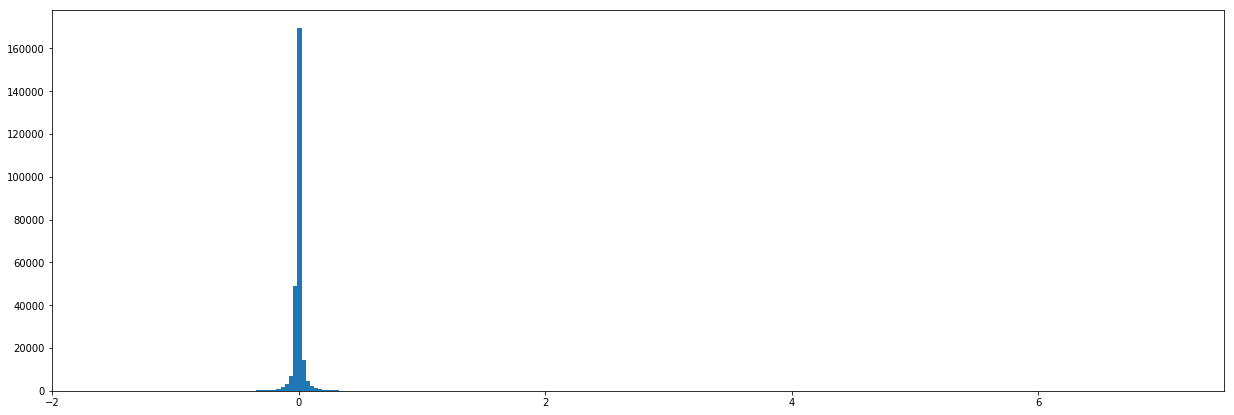

In [27]:
plt.hist(wc.ravel(), bins=255)
plt.show()

Using the window function below, we can define a threshold for setting small coefficients to 0.

In [28]:
def window(a, thresh):
    # iterate over all elements of a and set elements smaller
    # than thresh to 0
    # since we also want to write to elements, we need to specify 'readwrite'
    # and use the ellipsis [...] for assignment
    for e in np.nditer(a, op_flags=['readwrite']):
        if np.abs(e) < thresh:
            e[...] = 0
            
    return a

In [29]:
thresh = 0.01
wc = window(wc, thresh)

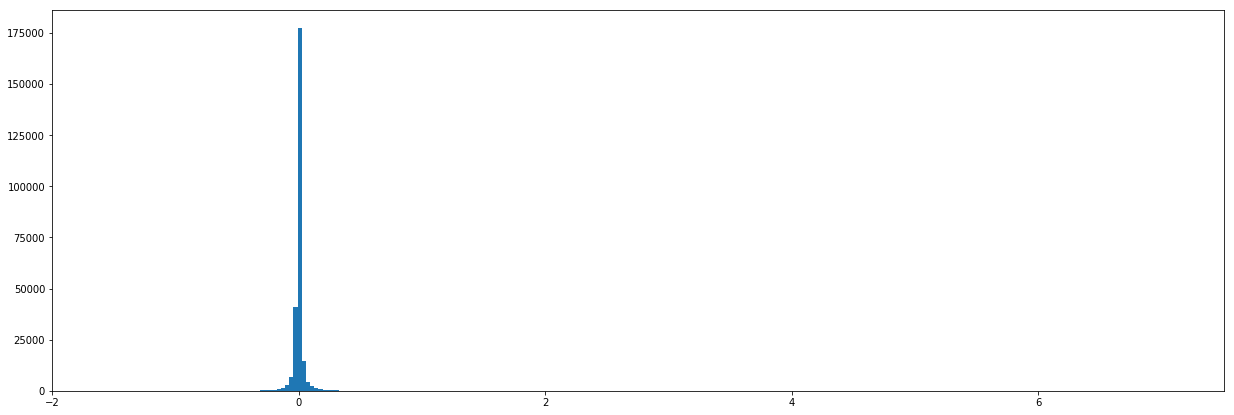

In [30]:
plt.hist(wc.ravel(), bins=255)
plt.show()

After thresholding our coefficients, we need to convert them back to an image, i.e. we have to revert the multi-resolution scheme.

In [31]:
def mrs2(waveletcoeffs, ndec):
    #resulting img
    img = np.copy(waveletcoeffs)

    [rows, cols] = np.shape(waveletcoeffs)
    # new rows and cols - divide old by 2^ndec
    rows //= 2 ** ndec
    cols //= 2 ** ndec

    #for every decade, create an image with the size of (2*rows,2*cols) by applying the idht2. The input are the images from 'mra'.
    for i in range(0, ndec):

        img[0:2*rows, 0:2*cols] = pywt.idwt2((img[0:rows, 0:cols], (img[0:rows, cols:2*cols], img[rows:2*rows, 0:cols], img[rows:2*rows, cols:2*cols])),'haar')

        rows *= 2
        cols *= 2

    return img

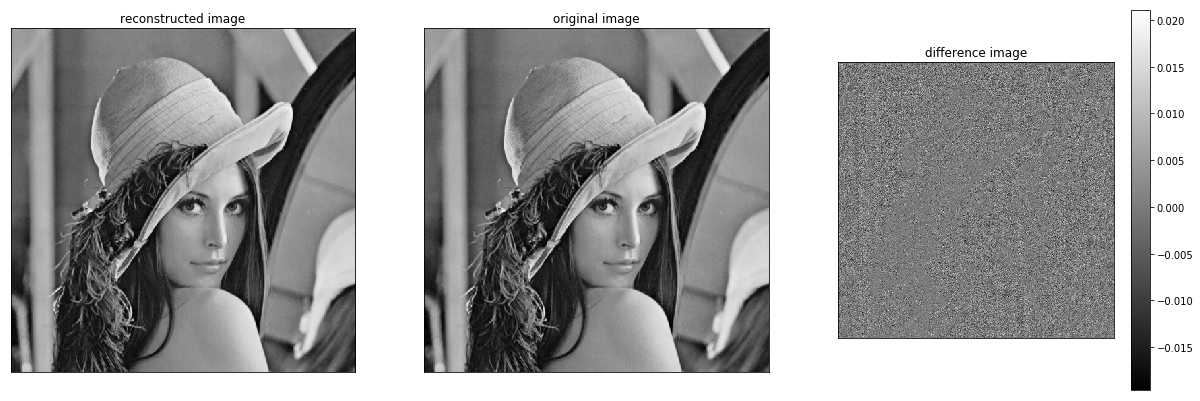

In [ ]:
img_r2 = mrs2(wc, ndec)

f1 = plt.subplot(1, 3, 1)
plt.xticks([]),plt.yticks([])
plt.imshow(img_r2, 'gray');
f1.set_title('reconstructed image');
f2 = plt.subplot(1, 3, 2)
plt.xticks([]),plt.yticks([])
plt.imshow(img, 'gray');
f2.set_title('original image');
f3 = plt.subplot(1, 3, 3)
plt.xticks([]),plt.yticks([])
plt.imshow(img-img_r2, 'gray');
plt.colorbar()
f3.set_title('difference image');

The code below produces transforms images for different numbers of resolution levels (y-axis) and thresholds (x-axis).

In [ ]:
thresholds = [0.05, 0.1, 0.2, 0.4]
scale_levels = 4
p = 1

fig = plt.figure(figsize(16, 16))
fig.text(0.5, 0.92, 'Thresholds', ha='center', va='center', fontsize=16)
fig.text(0.1, 0.5, 'Downsampling Steps', ha='center', va='center', rotation='vertical', fontsize=16)
for n in range(1, scale_levels + 1):
    wc = mra2(img, n)
    
    for t in thresholds:
        wc = window(wc, t)
        
        i = mrs2(wc, n)
        
        plt.subplot(scale_levels, np.size(thresholds), p)
        plt.xlabel('t =' + str(t))
        plt.ylabel('n =' + str(n))
        plt.xticks([]),plt.yticks([])
        plt.imshow(i, 'gray')
        p += 1


We can see from the artifacts in the images with higher thresholds that image areas become "blocky" in appearance. Omitting smaller coefficients means that changes of smaller amounts are not represented in the image anymore. More down-sampling steps mean that the blocky areas can become larger, since changes over larger areas are omitted by the thresholding. 

For now we assume that we can compress values of 0 without any cost (as stated in the exercise). What compression ration can we achieve by storing an image as thresholded coefficients? The number of values which are non-0 in our original image and which need to be stored is

In [ ]:
numNonZeroPixelsInImage = np.size(np.nonzero(img.ravel()))
print(numNonZeroPixelsInImage, 'of', np.prod(np.shape(img)))

The same number for our wavelet coefficents at $n=4$ and $t=0.05$

In [ ]:
wc = mra2(img, 5)
wc = window(wc, 0.4)

numNonZeroCoefficients = np.size(np.nonzero(wc.ravel()))
print(numNonZeroCoefficients, 'of', np.prod(np.shape(wc)))

We only need to store 7150 coeffcients compared to 65536 pixel. If we assume that a coefficient and a pixel both occupy one byte, we achieved a compression ration of

In [ ]:
print(numNonZeroCoefficients / numNonZeroPixelsInImage)

which is only 10% of our original image size with only some noticable loss in visual fidelity.